# Code for the Random Forest model

Contains full workflow from loading/downloading data, splitting data, full random forest defintion, testing, and results. The model is not saved because it is too large to be uploaded to github. Data is uploaded to github and loaded if it is found in your setup, otherwise it is downloaded and saved to drive

In [36]:
#imports
import yfinance as yf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display

In [37]:
# func to load ticker data
def load_ticker_windows(ticker, seq_len=30):
    file_path = f"content/{ticker}_daily_2018-2025.csv" # change if needed
    if not os.path.exists(file_path):
        df = yf.download(ticker, start="2018-01-01", end="2025-06-30",
                        interval="1d", auto_adjust=True) # date range over a day
        df.to_csv(file_path)
    else:
        df = pd.read_csv(file_path, index_col=0) # read if df already exsists

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] # OHLCV data
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)

    df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))# other measures

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    RS = roll_up / roll_down
    df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['BB_MID'] = df['Close'].rolling(20).mean()
    df['BB_STD'] = df['Close'].rolling(20).std()
    df['BB_UP'] = df['BB_MID'] + 2 * df['BB_STD']
    df['BB_DOWN'] = df['BB_MID'] - 2 * df['BB_STD']
    df['ATR'] = (df['High'] - df['Low']).rolling(14).mean()

    df.dropna(inplace=True) # drop bad data

    future_ret = df['log_ret'].rolling(5).sum().shift(-5)
    df['target'] = (future_ret > 0).astype(int) # buy if future return is +

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'BB_UP', 'BB_DOWN', 'ATR']
    mats, y, dates = [], [], []

    for i in range(seq_len, len(df)):
        mat = df.iloc[i-seq_len:i][features].values
        # no normalization, just flatten
        mats.append(mat.T.flatten())
        y.append(df['target'].iloc[i])
        dates.append(df.index[i])

    return np.stack(mats), np.array(y), df.iloc[seq_len:].reset_index()


In [38]:
#load all tickers
X_all, y_all, df_all_list = [], [], []
for ticker in ["AAPL", "MSFT", "GOOG", "AMZN", "META"]:
    X, y, df = load_ticker_windows(ticker)
    X_all.append(X)
    y_all.append(y)
    df_all_list.append(df)

X_all = np.concatenate(X_all) # combine all info
y_all = np.concatenate(y_all)
df_all = pd.concat(df_all_list).reset_index(drop=True) # again drop bad data

In [39]:
# split data, suffle, stratify
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2,
                                  random_state=42, stratify=y_all, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                random_state=42, stratify=y_temp, shuffle=True)

In [58]:
# init Random Forest without normalization and train
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
#takes ~1 min

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

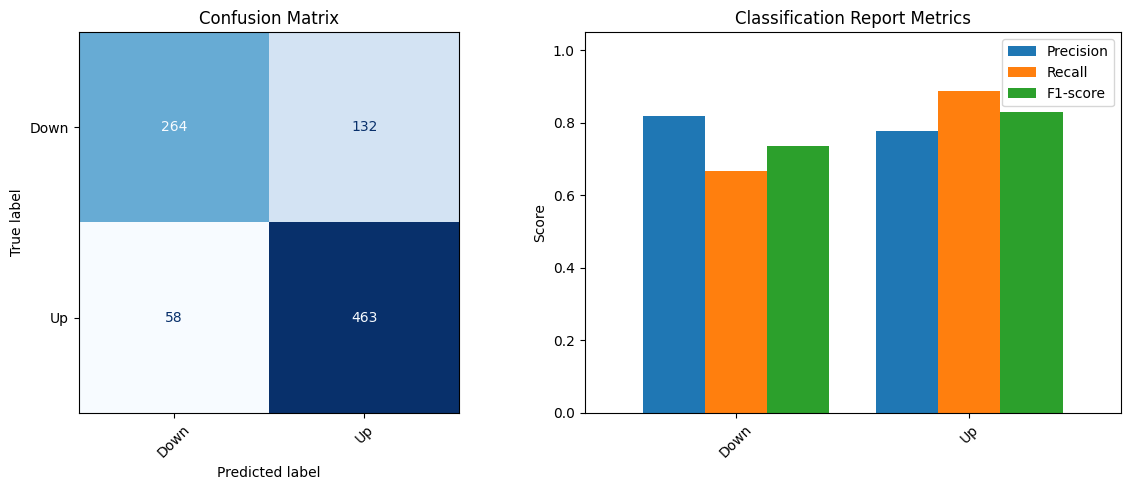

In [59]:
# evaluate the forest results by getting classification report
y_pred = rf.predict(X_test) # get predictions
cr_dict = classification_report(y_test, y_pred, target_names=['Down', 'Up'], output_dict=True)

# calc common eval scores
labels = ['Down', 'Up']
precision = [cr_dict[l]['precision'] for l in labels]
recall = [cr_dict[l]['recall'] for l in labels]
f1 = [cr_dict[l]['f1-score'] for l in labels]

# get cm
cm = confusion_matrix(y_test, y_pred)

# display cm
fig, (ax_cm, ax_bar) = plt.subplots(1, 2, figsize=(12, 5)) # makes subplots
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(
    cmap="Blues", xticks_rotation=45, ax=ax_cm, colorbar=False
)
ax_cm.set_title("Confusion Matrix")

# make the classification scores a chart
df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}, index=labels)
df.plot(kind='bar', ylim=(0, 1.05), ax=ax_bar, width=0.8)
ax_bar.set_ylabel('Score')
ax_bar.set_title('Classification Report Metrics')
ax_bar.tick_params(axis='x', rotation=45)

fig.tight_layout()
plt.show()

# Simulated Market

=== Buy-Hold Performance ===
Starting capital: $1,000,000.00
Ending capital: $2,279,737.93
Total $ growth: $1,279,737.93
Percentage growth: 127.97%

=== Profit vs Confidence ===
Threshold: 0.50 | Final: $1,170,703.96 | Net P/L: $170,703.96 | Trades: 599 | Avg Gain: 0.0184 | Avg Loss: -0.0186
Threshold: 0.60 | Final: $844,373.62 | Net P/L: $-155,626.38 | Trades: 450 | Avg Gain: 0.0187 | Avg Loss: -0.0200
Threshold: 0.70 | Final: $1,080,926.48 | Net P/L: $80,926.48 | Trades: 301 | Avg Gain: 0.0187 | Avg Loss: -0.0186
Threshold: 0.80 | Final: $1,017,200.93 | Net P/L: $17,200.93 | Trades: 106 | Avg Gain: 0.0216 | Avg Loss: -0.0222
Threshold: 0.85 | Final: $819,915.85 | Net P/L: $-180,084.15 | Trades: 48 | Avg Gain: 0.0195 | Avg Loss: -0.0272
Threshold: 0.90 | Final: $719,933.47 | Net P/L: $-280,066.53 | Trades: 12 | Avg Gain: 0.0165 | Avg Loss: -0.0445
Threshold: 0.95 | Final: $976,719.67 | Net P/L: $-23,280.33 | Trades: 1 | Avg Gain: 0.0000 | Avg Loss: -0.0233


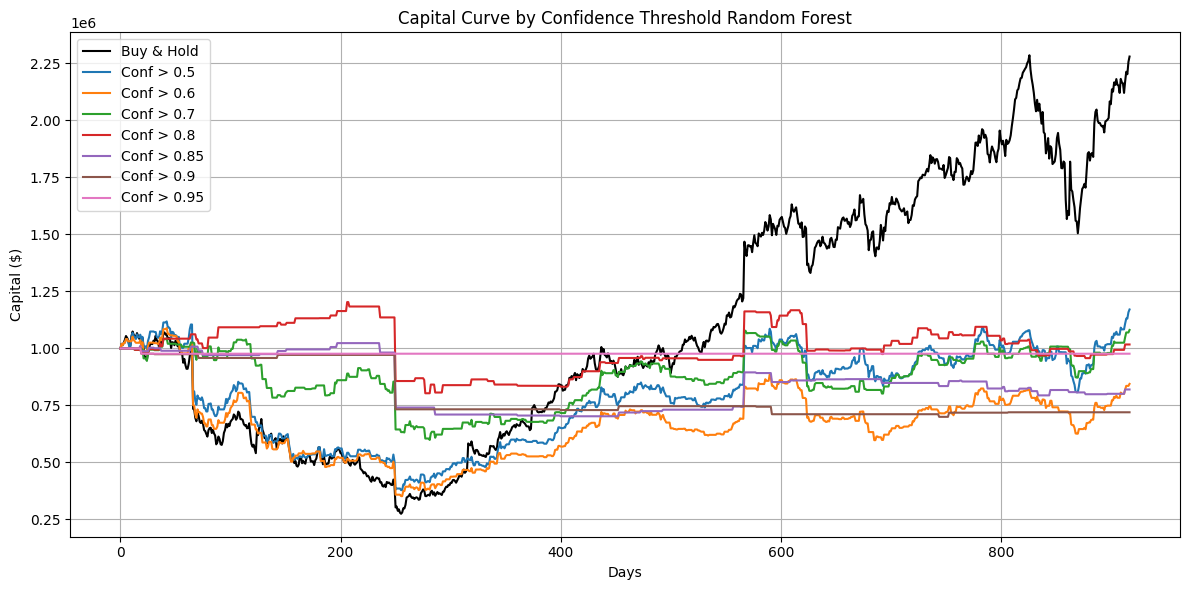

In [57]:
# setup simulated marked
probs = rf.predict_proba(X_test) # this function predicts buy/sell with probability, allows for confidence score to be implemented
confidences = np.max(probs, axis=1)
y_pred_conf = np.argmax(probs, axis=1)

# get retruns
returns = np.exp(df_all['log_ret'].values) - 1
test_returns = returns[-len(y_pred_conf):]
initial_capital = 1000000.0


# calc buy-and-hold info
stock_capital = initial_capital
stock_curve = [stock_capital]

for ret in test_returns:
    stock_capital *= (1 + ret)
    stock_curve.append(stock_capital)

stock_growth = stock_capital - initial_capital
stock_pct_growth = (stock_capital / initial_capital - 1) * 100

# print buy-hold results
print("=== Buy-Hold Performance ===")
print(f"Starting capital: ${initial_capital:,.2f}")
print(f"Ending capital: ${stock_capital:,.2f}")
print(f"Total $ growth: ${stock_growth:,.2f}")
print(f"Percentage growth: {stock_pct_growth:.2f}%\n")

# add to plt
plt.figure(figsize=(12, 6))
plt.plot(stock_curve, label="Buy & Hold", linestyle="-", color="black")

# determine trades and money made based on confidence thresh
thresholds = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]
results = []

for thresh in thresholds:
    capital = initial_capital
    capital_curve = [capital]
    trade_count = 0
    profit_trades, loss_trades = [], []

    # determines the trades made and return
    for ret, pred, conf in zip(test_returns, y_pred_conf, confidences):
        if pred == 1 and conf > thresh:
            trade_count += 1
            capital *= (1 + ret)
            (profit_trades if ret >= 0 else loss_trades).append(ret)
        capital_curve.append(capital)

    results.append({
        'threshold': thresh,
        'final_capital': capital,
        'net_PL': capital - initial_capital,
        'total_trades': trade_count,
        'avg_gain': np.mean(profit_trades) if profit_trades else 0,
        'avg_loss': np.mean(loss_trades) if loss_trades else 0,
    })

    # add to plt
    plt.plot(capital_curve, label=f"Conf > {thresh}")

# print results
print("=== Profit vs Confidence ===")
for r in results:
    print(f"Threshold: {r['threshold']:.2f} | Final: ${r['final_capital']:,.2f} | "
          f"Net P/L: ${r['net_PL']:,.2f} | Trades: {r['total_trades']} | "
          f"Avg Gain: {r['avg_gain']:.4f} | Avg Loss: {r['avg_loss']:.4f}")

# plot
plt.title("Capital Curve by Confidence Threshold Random Forest")
plt.xlabel("Days")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
